In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import string
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
# !pip install transformers
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings

warnings.filterwarnings("ignore")

# logging.set_verbosity_error()

c:\Users\GroooDev\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 1
N_SPLITS = 5
print(device)

cuda:0


In [4]:
df = pd.read_csv("./data/data_5_label.csv")
df = df.drop(index=df.loc[df.text.map(type) == float].index)
df = df.reset_index(drop=True)
print(df.label.value_counts())
df

0    4874
3    1804
1    1522
2    1134
4     990
Name: label, dtype: int64


,Unnamed: 0,text,label
0,495,nhắc nhẹ,0
1,498,cx ge kkk,0
2,500,nhàng mấy trách,0
3,501,trách kỹ mấy la,0
4,502,ngã gấp đôi mấy,0
...,...,...,...
10319,5334,ku bu e ren hu hu love,4
10320,5335,buom e chay cho a,4
10321,5336,ban bim lun,4
10322,5337,a dam hok,4


In [5]:
df.loc[df.label >0, 'label'] = 1

In [6]:
# load stopwords vn
with open("./vietnamese.txt", 'r', encoding="utf8") as f:
    stop_words = [word[:-1] for word in f]
len(stop_words)

1943

In [7]:
# # Special thanks to https://www.kaggle.com/tanulsingh077 for this function
# def clean_text(text):
#     '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
#     and remove words containing numbers.'''
#     text = str(text).lower()
#     text = re.sub('\[.*?\]', '', text)
#     text = re.sub('https?://\S+|www\.\S+', '', text)
#     text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\w*\d\w*', '', text)
#     return text
# def preprocess_data(text):
#     # Clean puntuation, urls, and so on
#     text = clean_text(text)
#     # Remove stopwords
#     text = ' '.join(word for word in text.split(' ') if word not in stop_words)
#     return text

In [8]:
# df['comments_clean'] = df['comments'].apply(preprocess_data)
# df

In [9]:
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.label.value_counts())
print(test_df.label.value_counts())
train_df = train_df.reset_index(drop=True)

skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold
train_df


1    4925
0    4366
Name: label, dtype: int64
1    525
0    508
Name: label, dtype: int64


,Unnamed: 0,text,label,kfold
0,8992,dai phat truyen thong,0,0.0
1,6727,bich hanh nguyen thuong nha,0,0.0
2,9250,nhiet chao mung giai phong mien nam thong dat...,1,0.0
3,6364,trend chay than lien gig,0,0.0
4,6573,san pham la viet nam,1,0.0
...,...,...,...,...
9286,2114,văn phòng phương án lợi công,0,4.0
9287,2275,vn thể miễn thu tiền,1,4.0
9288,6863,sau roi,0,4.0
9289,5095,lol dep,1,4.0


In [10]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
class SensitiveDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=60):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def labelencoder(self, label):
        if (label == 0) | (label == 'normal'): 
            return 0
        elif (label == 1) | (label == 'harassment'): #quấy rối
            return 1
        elif (label == 2) | (label == 'profanitie'): #tục tĩu
            return 2
        elif (label == 3) | (label == 'political'): #khiêu dâm/cực đoan
            return 3
        elif (label == 4) | (label == 'pornographic'): #chính trị
            return 4

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['text']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['label'])
        return text, label

In [12]:
all_data = df.text.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [
    tokenizer.encode(text, add_special_tokens=True) for text in all_data
]
token_lens = [len(text) for text in encoded_text]


Text(0.5, 8.95999999999998, 'Token Count')

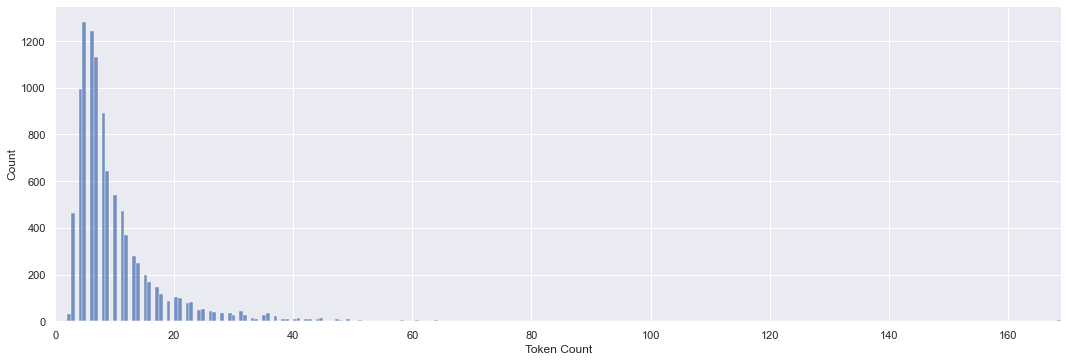

In [13]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.displot(token_lens, height=5, aspect=3)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')

In [14]:
class SensitiveClassifier(nn.Module):
    def __init__(self):
        super(SensitiveClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base",
                                              local_files_only=True)

        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 2)
        self.relu = nn.ReLU()
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask = None):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False  # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        x = self.relu(x)
        return x

In [15]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        # attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids)

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(
        f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}'
    )


def eval(test_data=False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            # attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(input_ids=input_ids)

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(
            f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}'
        )
        return correct.double() / len(test_loader.dataset)
    else:
        print(
            f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}'
        )
        return correct.double() / len(valid_loader.dataset)


In [16]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SensitiveDataset(df_train, tokenizer, max_len=60)
    valid_dataset = SensitiveDataset(df_valid, tokenizer, max_len=60)

    train_loader = DataLoader(train_dataset,
                              batch_size=16,
                              shuffle=True,
                              num_workers=2)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=16,
                              shuffle=True,
                              num_workers=2)

    return train_loader, valid_loader

In [17]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SensitiveClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=len(train_loader) * EPOCHS)
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-' * 30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/1
------------------------------


In [ ]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=2)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(input_ids=input_ids,
                                attention_mask=attention_mask)
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SensitiveDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=True,
                         num_workers=2)
real_values, predicts = test(test_loader)

In [ ]:
class_names = ['Normal', 'Sensitive']

In [ ]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label


for i in range(15):
    print('-' * 50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].comments_clean)
    print(
        f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})'
    )


In [ ]:
infer("Chứng khoán dạo này chán quá", tokenizer)


In [ ]:
df.loc[df.label == 4]

,Unnamed: 0,text,label
9334,0,tê bướm hi,4
9335,1,xinh dã man,4
9336,2,nứng r,4
9337,3,bắn bướm e đi mấy a,4
9338,4,yuki hodaka vú đẹp,4
...,...,...,...
10319,5334,ku bu e ren hu hu love,4
10320,5335,buom e chay cho a,4
10321,5336,ban bim lun,4
10322,5337,a dam hok,4
